In [87]:
import numpy as np
import math 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from functools import partial

In [90]:
%matplotlib notebook

In [2]:
def u(x, y, t):
    return (1 + x * y + ((np.exp(t) - np.exp((-np.pi**2)*t)) / (1 + np.pi**2)) * np.cos(np.pi * x / 2) * 
            np.sin(np.pi * y / 2))

def mu(t, x, y):
    if t == 0:
        return 1 + x*y
    elif x == 0:
        return 1 + ((np.exp(t) - np.exp(-np.pi**2*t)) / (1 + np.pi**2)) * np.sin(np.pi * y / 2)
    elif x == 1:
        return 1 + y
    elif y == 0:
        return 1
    elif y == 1:
        return 1 + x + ((np.exp(t) - np.exp(-np.pi**2*t)) / (1 + np.pi**2)) * np.cos(np.pi * x / 2)
    else:
        return 0

In [122]:
def plot(y, u, h1, h2):
    x1, x2 = np.arange(0, 1 + h1, h1), np.arange(0, 1 + h2, h2)
    
    xx1, xx2 = np.meshgrid(x1, x2, indexing='ij')
    z = np.vectorize(u)(xx1, xx2) 
    
    fig = plt.figure(figsize=(10, 6))
    ax = Axes3D(fig)
    
    ax.scatter3D(xx1, xx2, y, s=2, color='black') # график численного решения
    ax.plot_surface(xx1, xx2, z, color='white') # график точного решения
    
    ax.set_xlabel(r'$x1$')
    ax.set_ylabel(r'$x2$')

In [9]:
# реализация метода прогонки
def TDMA(a, b, c, d):
    a_, b_, c_, d_ = map(np.array, (a, b, c, d))
    n = len(d)
    
    for i in range(1, n):
        w = a_[i - 1] / b_[i - 1]
        b_[i] = b_[i] - w * c_[i - 1]
        d_[i] = d_[i] - w * d_[i - 1]
        
    x = np.zeros_like(d)
    x[-1] = d_[-1] / b_[-1]
    
    for i in range(n - 2, -1, -1):
        x[i] = (d_[i] - c_[i] * x[i + 1]) / b_[i]
        
    return x

In [74]:
def Lambda_vectorized(alpha, y, h, k):
    if y.ndim != 2:
        raise ValueError("y should be 2-dimensional")
    if alpha == 1:
        return (1 / h**2) * (y[k + 1, 1:-1] - 2 * y[k, 1:-1] + y[k - 1, 1:-1])
    elif alpha == 2:
        return (1 / h**2) * (y[1:-1, k + 1] - 2 * y[1:-1, k] + y[1:-1, k - 1])
    else:
        raise ValueError("Wrong value of alpha")
        
def Lambda(alpha, y, h, i, j):
    if y.ndim != 2:
        raise ValueError("y should be 2-dimensional")
    if alpha == 1:
        return (1 / h**2) * (y[i + 1, j] - 2 * y[i, j] + y[i - 1, j])
    elif alpha == 2:
        return (1 / h**2) * (y[i, j + 1] - 2 * y[i, j] + y[i, j - 1])
    else:
        raise ValueError("Wrong value of alpha")

In [101]:
def ADI(mu, T, tau, h1, h2):
    K, N1, N2 = math.ceil(T / tau), math.ceil(1 / h1), math.ceil(1 / h2)
    t, x1, x2 = np.arange(0, T + tau, tau), np.arange(0, 1 + h1, h1), np.arange(0, 1 + h2, h2)
    tt, x1x1, x2x2 = np.meshgrid(t, x1, x2, indexing='ij')
    y = np.zeros((K + 1, N1 + 1, N2 + 1))
    y = np.vectorize(mu)(tt, x1x1, x2x2)
    gamma1 = 1 / h1**2
    gamma2 = 1 / h2**2
    for n in range(1, K + 1):
        w = np.zeros((N1 + 1, N2 + 1))
        w[0, 1:N2] = (1 / 2) * (y[n, 0, 1:N2] + y[n - 1, 0, 1:N2]) - ((tau / 4) * np.array([Lambda(2, y[n] - y[n - 1], h2, 0, j) 
                                                                          for j in range(1, N2)]))
        for j in range(1, N2):
            w[1:N1, j] = TDMA(np.full(N1 - 2, -gamma1), np.full(N1 - 1, 2 / tau + 2 * gamma1), 
                              np.full(N1 - 2, -gamma1), (2 / tau) * y[n, 1:N1, j] + Lambda_vectorized(2, y[n], h2, j))
        for i in range(1, N1):
            y[n, i, 1:N2] = TDMA(np.full(N2 - 2, -gamma2), np.full(N2 - 1, 2 / tau + 2 * gamma2), 
                              np.full(N2 - 2, -gamma2), (2 / tau) * w[i, 1:N2] + Lambda_vectorized(1, w, h1, i))
        
    return y
        

In [126]:
T = 0.1
tau = 0.01
h1 = 0.05
h2 = 0.05

In [127]:
y = ADI(mu, T, tau, h1, h2)

<IPython.core.display.Javascript object>


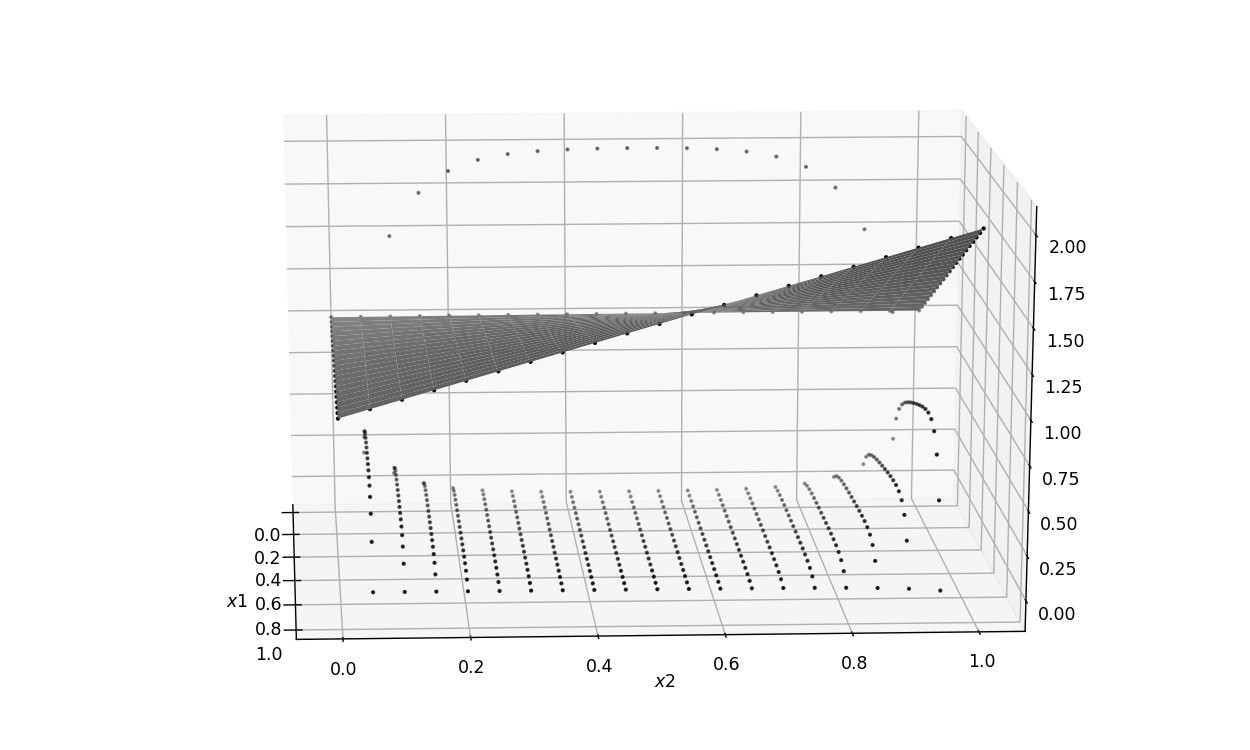

In [128]:
plot(y[1], partial(u, t=0.01), h1, h2)

In [72]:
T = 1
tau = 0.2
h1 = 0.1
h2 = 0.25
K, N1, N2 = math.ceil(T / tau), math.ceil(1 / h1), math.ceil(1 / h2)
t, x1, x2 = np.arange(0, T + tau, tau), np.arange(0, 1 + h1, h1), np.arange(0, 1 + h2, h2)
tt, x1x1, x2x2 = np.meshgrid(t, x1, x2, indexing='ij')
y = np.zeros((K + 1, N1 + 1, N2 + 1))
y = np.vectorize(mu)(tt, x1x1, x2x2)
z = np.zeros(N2 + 1)
n = 1
(1 / 2) * (y[n + 1, 0, 1:N2] + y[n, 0, 1:N2]) - ((tau / 4) * np.array([Lambda(2, y[n + 1] - y[n], h2, j) 
                                                                          for j in range(1, N2)]))

array([1.04497697, 1.08310661, 1.10858402])